# MPB mode-solver

[MPB](https://mpb.readthedocs.io/en/latest/Python_Tutorial/#our-first-band-structure) is a free open source software to compute:

- electro-magnetic modes
- band structures

supported by a waveguide with periodic boundaries.


## Find modes waveguide

Lets find the modes supported by a waveguide for a particular waveguide geometry and wavelength.

A waveguide is like a pipe to guide the light and is made of a higher refractive index core `ncore` surrounded by a lower refractive index cladding `nclad`


```bash
          __________________________
          |
          |
          |         width
          |     <---------->
          |      ___________   _ _ _
          |     |           |       |
        sz|_____|           |_______|
          |                         | wg_thickness
          |slab_thickness           |
          |_________________________|
          |
          |
          |__________________________
          <------------------------>
                        sy
```

Silicon is yellow and opaque at visible wavelengths (380 to 700nm). This is the reason why CMOS cameras can be made of Silicon.

At Infra-red wavelengths used for communications (1300 or 1550nm) Silicon is transparent and has a high refractive index `3.47`. So making a Silicon waveguide is quite easy, where the Silicon is the guiding material, and Silicon oxide `n=1.45` makes a great low index material for the cladding of the waveguide.


This [video](https://www.youtube.com/watch?v=Hy7yn2xohlE) explains how Silicon Photonic waveguides guide light in Photonic integrated circuits.



### Strip waveguides

Strip waveguides are fully etch and don't have a slab. `slab_thickness = 0`


```bash
          __________________________
          |
          |
          |         width
          |     <---------->
          |      ___________   _ _ _
          |     |           |       |
        sz|     |           |       |
          |     |  ncore    |       | wg_thickness
          |     |           |       |
          |     |___________|  _ _ _|
          |
          |        nclad
          |__________________________
          <------------------------>
                        sy
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory.simulation.modes as gm

Using MPI version 4.0, 1 processes


2022-11-07 00:11:46.298 | INFO     | gdsfactory.config:<module>:45 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.54.0


/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2022-11-07 00:11:48.188 | INFO     | gdsfactory.simulation.gmeep:<module>:32 - Meep '1.24.0' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


In [2]:
modes = gm.find_modes_waveguide(
    parity=mp.NO_PARITY,
    wg_width=0.4,
    ncore=3.47,
    nclad=1.44,
    wg_thickness=0.22,
    resolution=40,
    sy=3,
    sz=3,
    nmodes=4,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]

As you can see the refractive index goes from 1.44 `SiO2` Silicon dioxide to 3.47 `Silicon`.

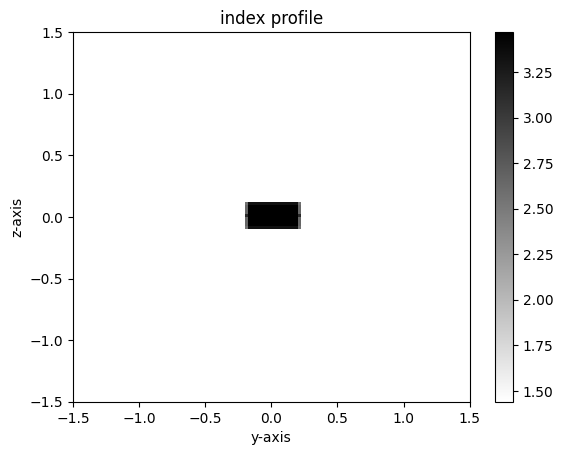

In [3]:
m1.plot_eps()

In [4]:
m1.neff

2.217943213005528

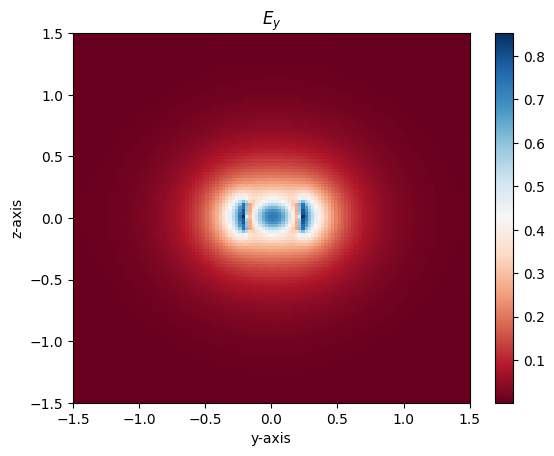

In [5]:
m1.plot_ey()

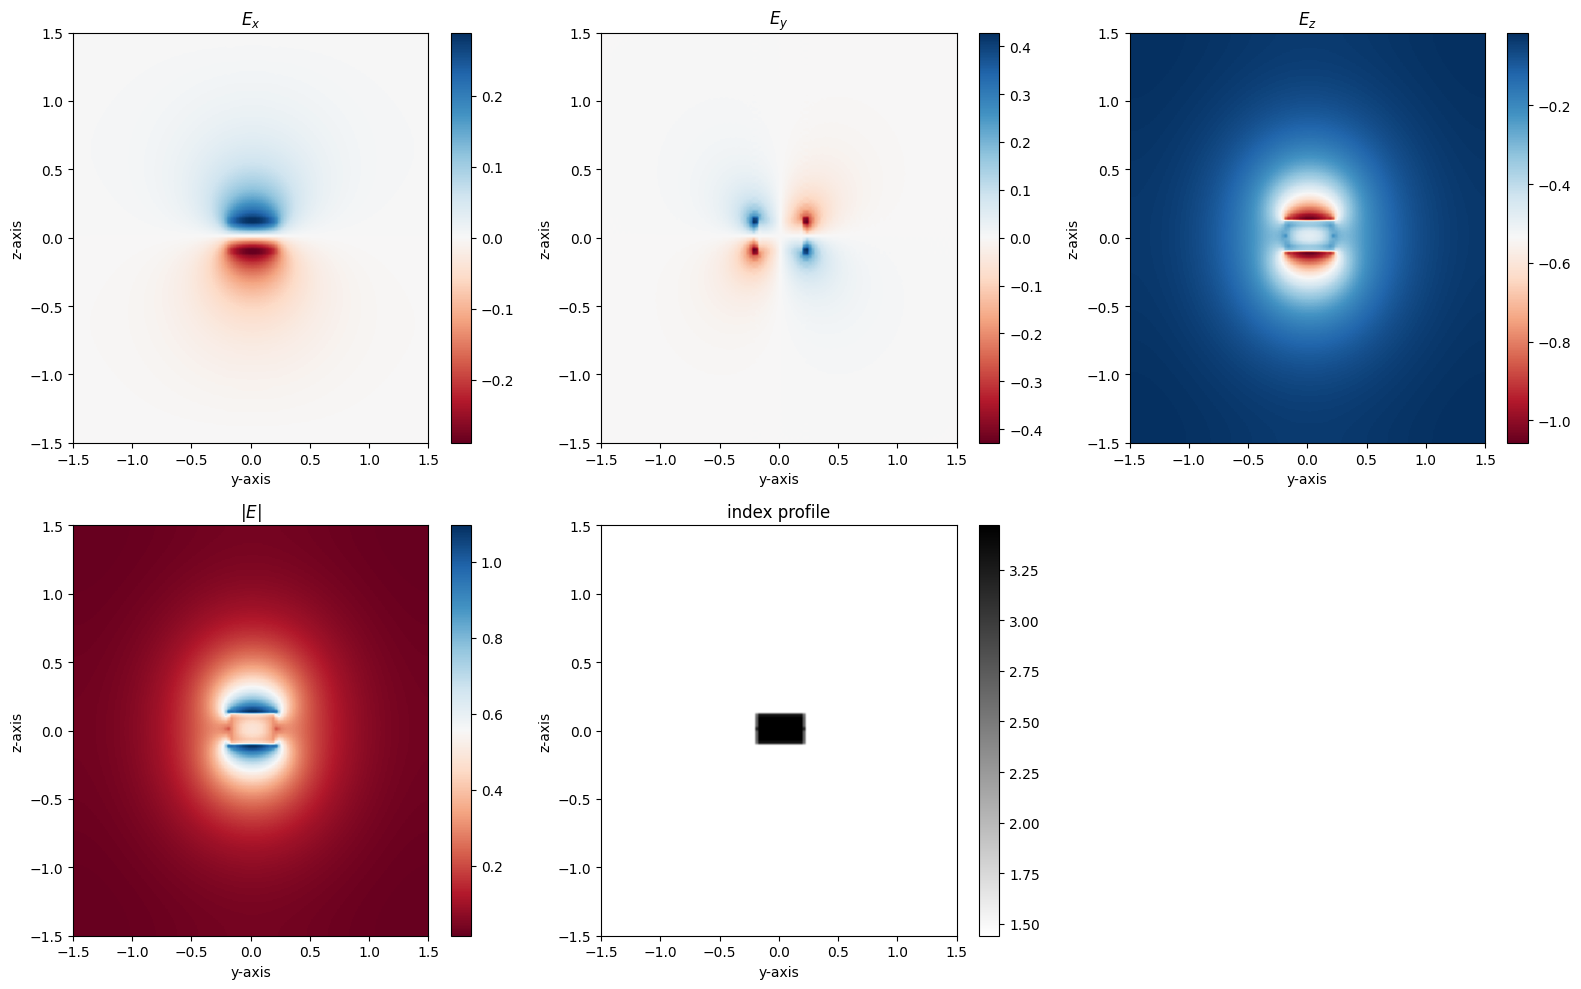

In [6]:
m2.plot_e_all()

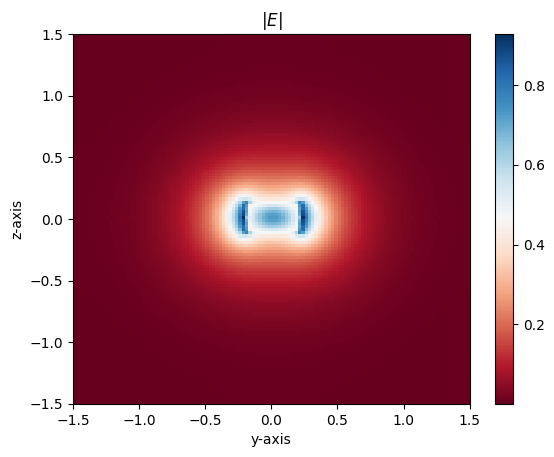

In [7]:
m1.plot_e()

As you can see the first order mode has most power in y-direction `Ey`. This type of mode is called TE (transverse-electric)

On the other hand the second order mode has most of the light in the `Ex`. This mode is called TM (transverse-magnetic)

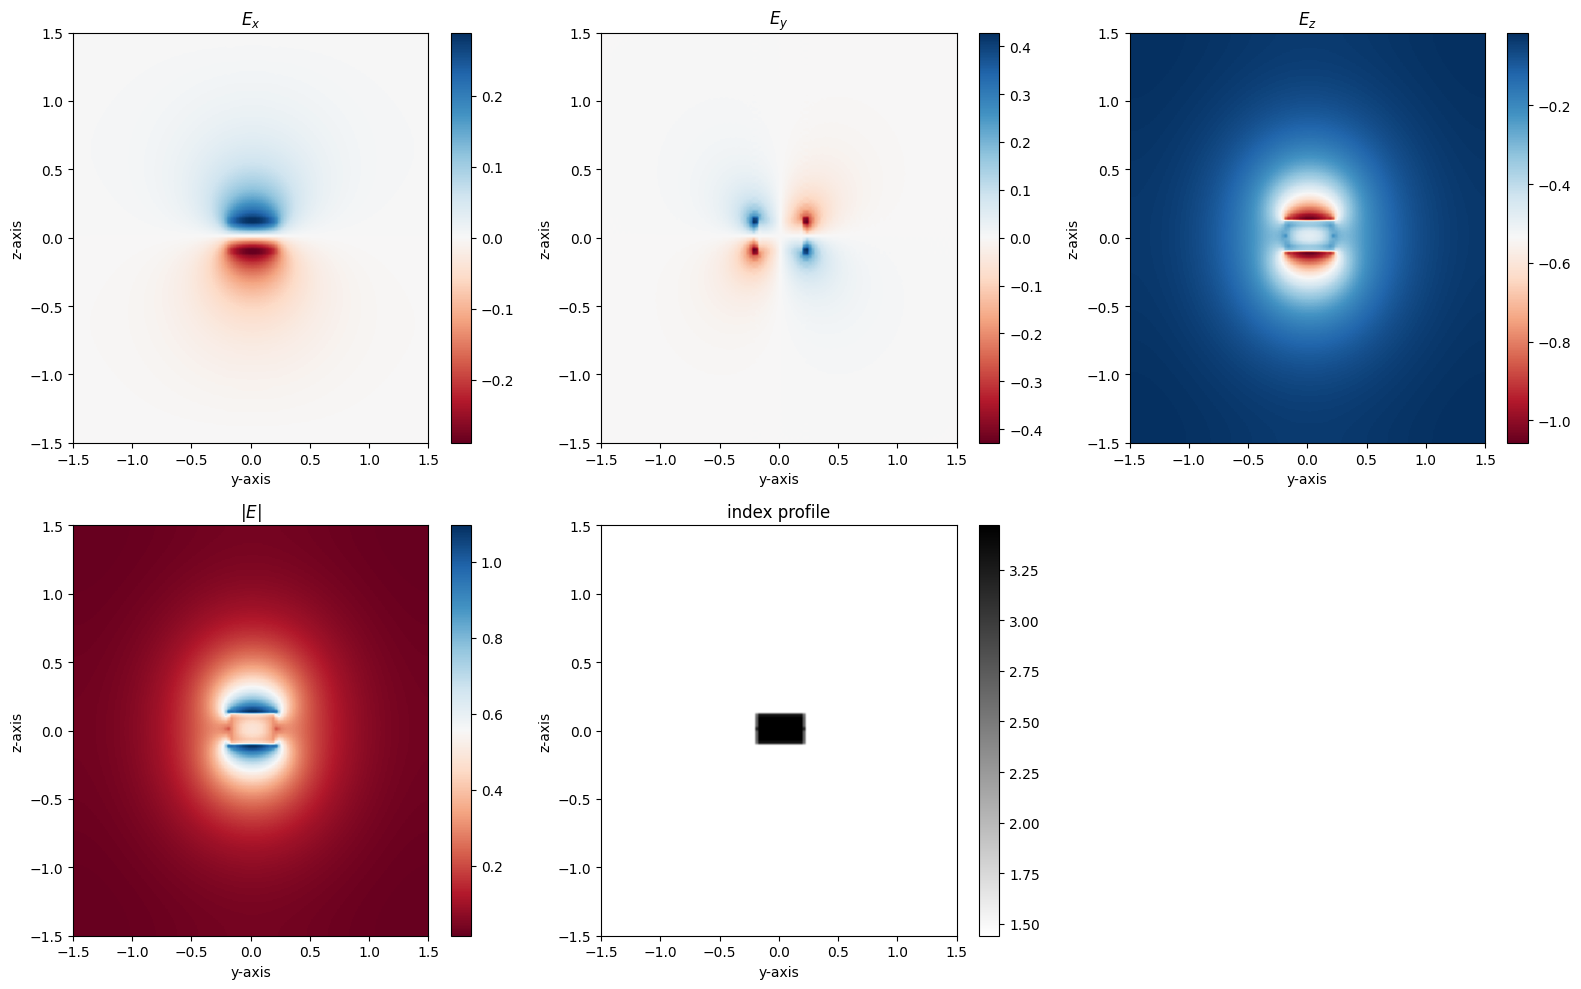

In [8]:
m2.plot_e_all()

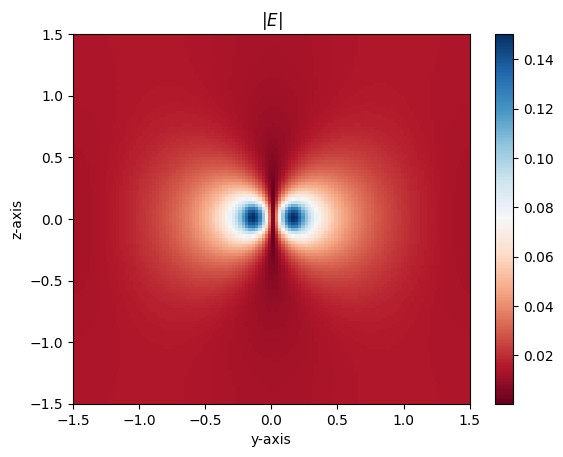

In [9]:
m3.plot_e()  # not guided

In [10]:
m1.neff

2.217943213005528

In [11]:
m2.neff

1.6821915254197568

In [12]:
# the third mode does not propagate and its neff is below the cladding index
m3.neff

1.4306966356075508

### Sidewall angle

You can also specify the sidewall angle.

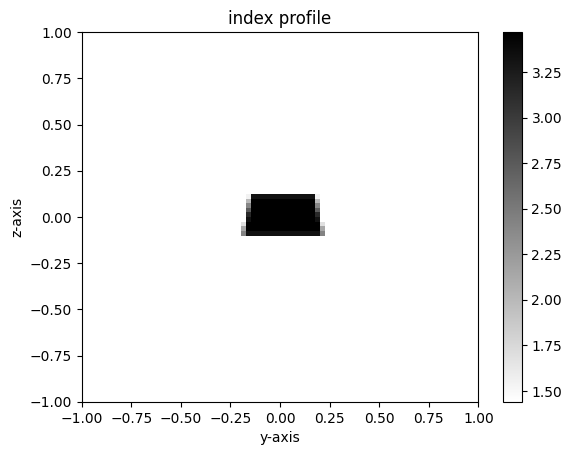

In [13]:
modes = gm.find_modes_waveguide(
    parity=mp.NO_PARITY,
    wg_width=0.4,
    ncore=3.47,
    nclad=1.44,
    wg_thickness=0.22,
    resolution=40,
    sidewall_angle=10,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]
m1.plot_eps()

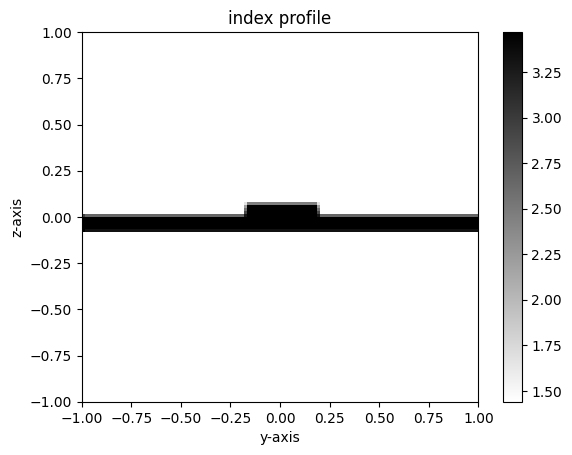

In [14]:
modes = gm.find_modes_waveguide(
    parity=mp.NO_PARITY,
    wg_width=0.4,
    ncore=3.47,
    nclad=1.44,
    wg_thickness=0.22,
    resolution=60,
    sidewall_angle=10,
    slab_thickness=90e-3,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]
m1.plot_eps()

### Rib waveguides

Rib waveguides have a slab (not fully etched)

In [15]:
import gdsfactory.simulation.modes as gm
import meep as mp

modes = gm.find_modes_waveguide(
    mode_number=1, nmodes=2, slab_thickness=90e-3, resolution=40
)
m1 = modes[1]
m2 = modes[2]

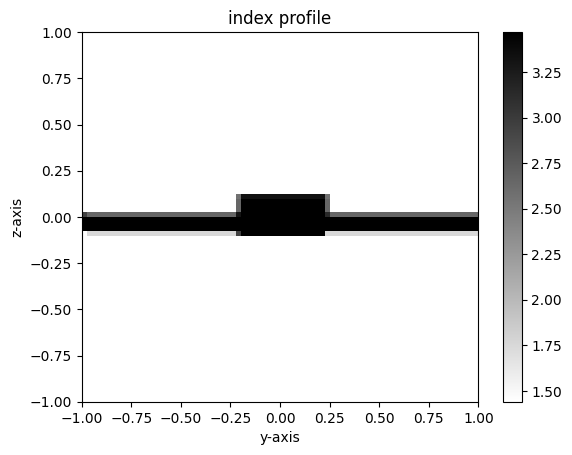

In [16]:
m1.plot_eps()

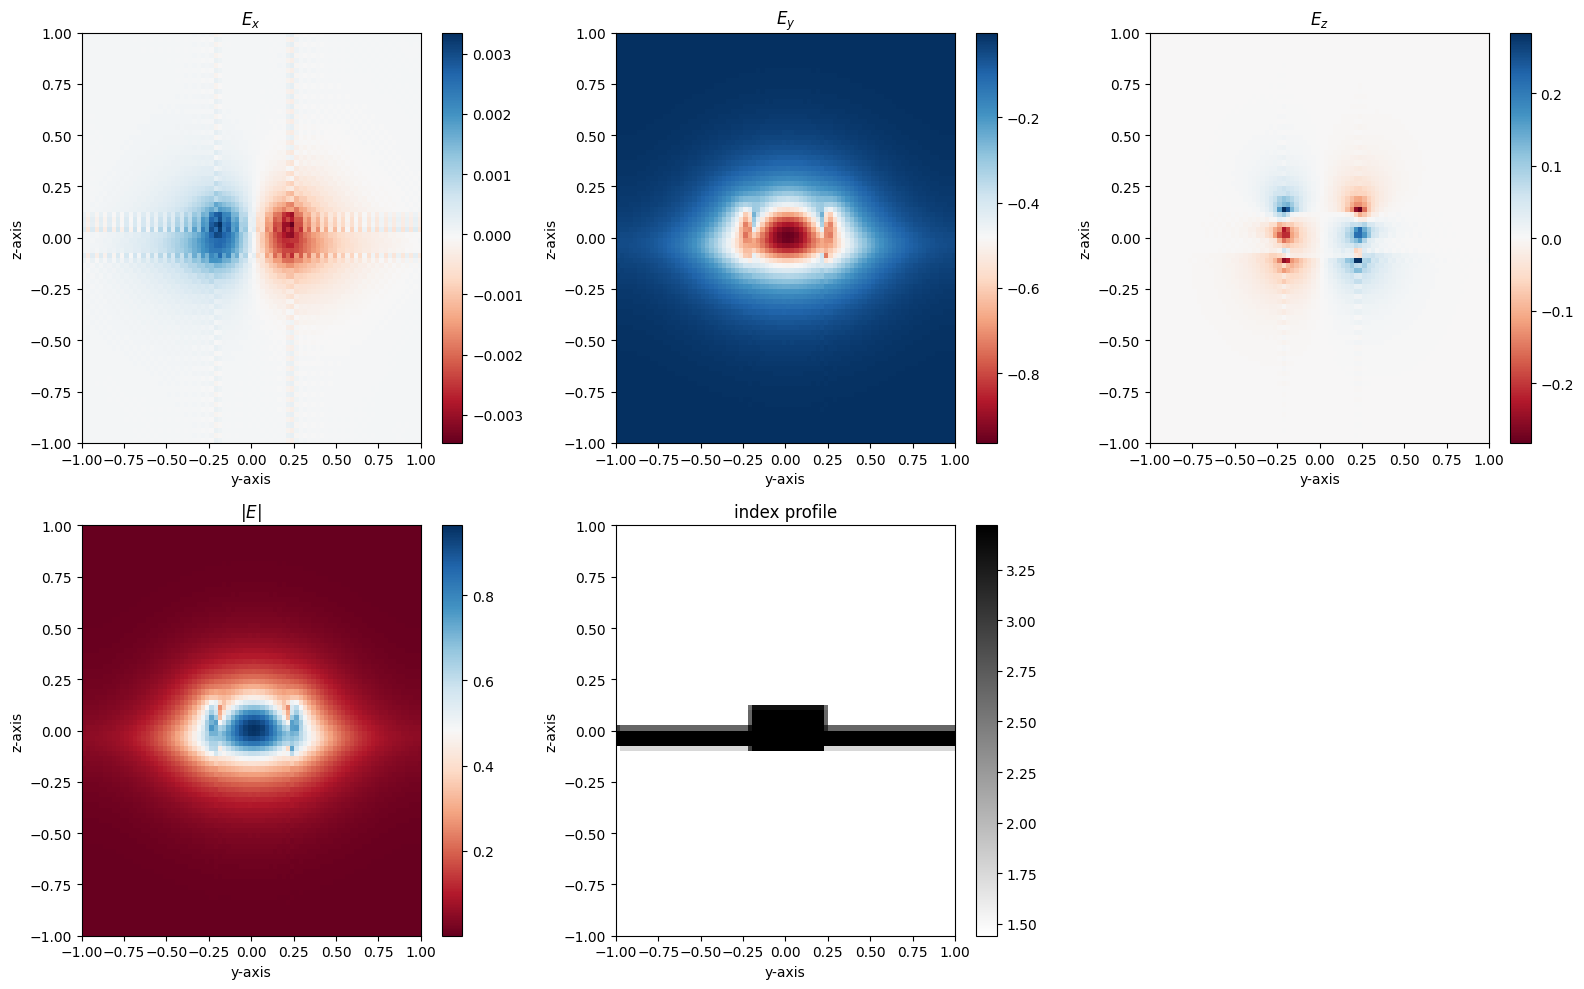

In [17]:
m1.plot_e_all()

## Symmetries

You can exploit symmetries to reduce computation time as well as finding only (TE or TM) modes

MPB assumes propagation in the X direction

- TE: mp.ODD_Y + mp.EVEN_Z
- TM: mp.EVEN+Y + mp.ODD_Z, all energy in z component

### TM: mp.ODD_Y + mp.EVEN_Z

You can define an even Y parity to find only the TM modes

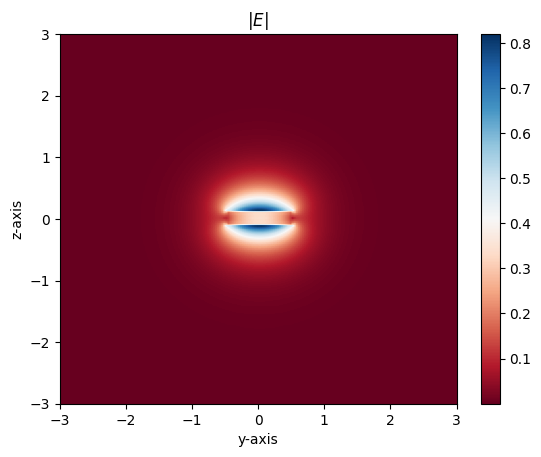

In [18]:
modes = gm.find_modes_waveguide(
    mode_number=1,
    parity=mp.EVEN_Y + mp.ODD_Z,
    nmodes=2,
    wg_width=1.0,
    ncore=3.47,
    nclad=1.44,
    wg_thickness=0.22,
    resolution=32,
    sy=6,
    sz=6,
)
m1 = modes[1]
m2 = modes[2]
m1.plot_e()

### ODD_Y (TE)

In [19]:
modes = gm.find_modes_waveguide(
    mode_number=1,
    parity=mp.ODD_Y,
    nmodes=2,
    wg_width=0.20,
    ncore=3.47,
    nclad=1.44,
    wg_thickness=0.22,
    resolution=20,
    sy=5,
    sz=5,
)
m1 = modes[1]
m2 = modes[2]

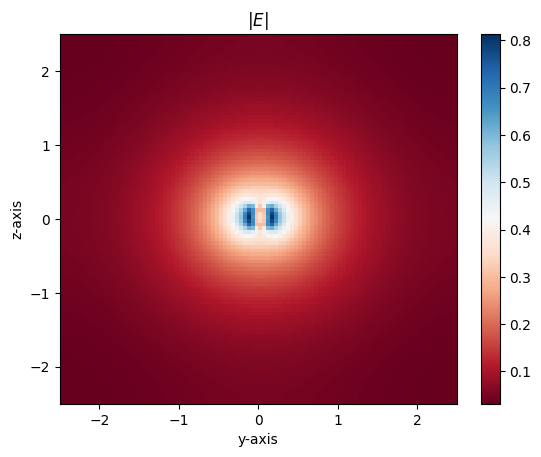

In [20]:
m1.plot_e()

## Sweep waveguide width

### Strip

In [21]:
df = gm.find_neff_vs_width(filepath="neff_vs_width.csv")
df

,1,2,3,4,width
0,1.499770,1.488664,1.328191,1.316624,0.200000
1,1.683443,1.556811,1.384970,1.358053,0.272727
2,2.031569,1.632182,1.406476,1.375044,0.345455
3,2.261402,1.692583,1.413844,1.400262,0.418182
4,2.410539,1.744925,1.418374,1.418373,0.490909
5,2.508256,1.788094,1.580987,1.422537,0.563636
6,2.577841,1.823844,1.767065,1.428408,0.636364
7,2.627689,1.958723,1.853650,1.438660,0.709091
8,2.665757,2.122754,1.880209,1.489468,0.781818
9,2.691444,2.236792,1.898304,1.540170,0.854545


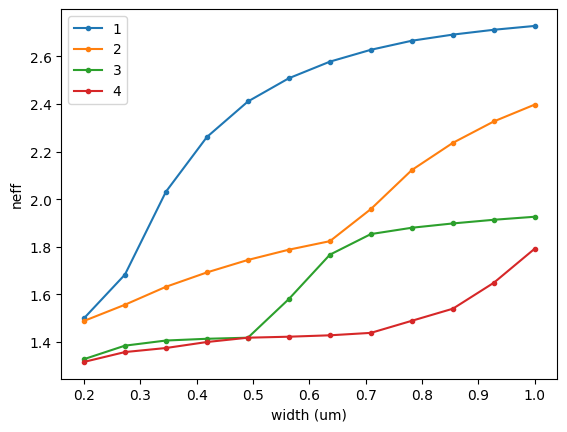

In [22]:
gm.plot_neff_vs_width(df)

### Rib

In [23]:
import matplotlib.pyplot as plt
import gdsfactory.simulation.modes as gm
import meep as mp

modes = gm.find_modes_waveguide(
    wg_width=0.4,
    ncore=3.47,
    nclad=1.44,
    wg_thickness=220e-3,
    resolution=20,
    sz=6,
    sy=6,
    nmodes=4,
    slab_thickness=90e-3,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]

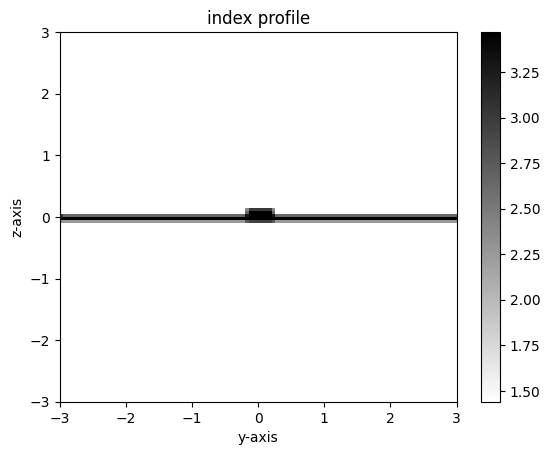

2.4460498094987972

In [24]:
m1.plot_eps()
m1.neff

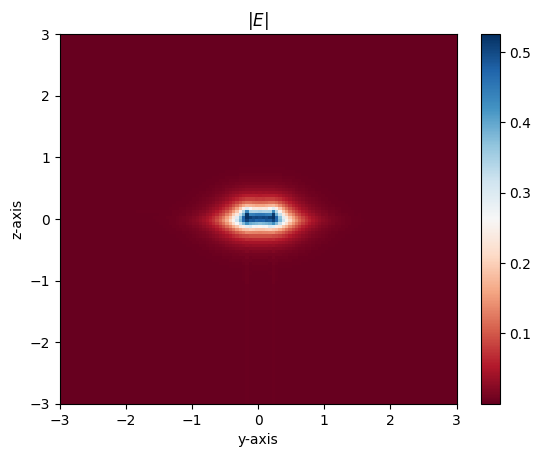

2.4460498094987972

In [25]:
m1.plot_e()
m1.neff

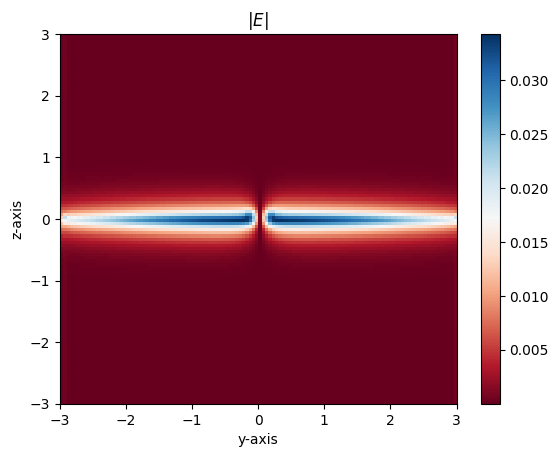

2.0596792177834424

In [26]:
m2.plot_e()
m2.neff

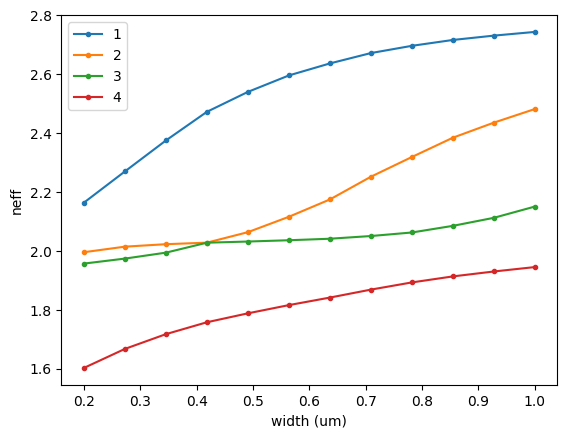

In [27]:
df = gm.find_neff_vs_width(slab_thickness=90e-3, filepath="neff_vs_width_rib.csv")
gm.plot_neff_vs_width(df)

### Nitride

In [28]:
modes = gm.find_modes_waveguide(
    wg_width=1.0,
    ncore=2.0,
    nclad=1.44,
    wg_thickness=400e-3,
    sz=6,
    sy=10,
    nmodes=4,
    resolution=10,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]

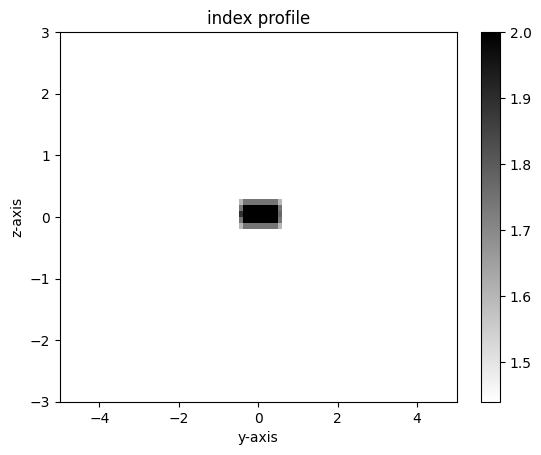

In [29]:
m1.plot_eps()

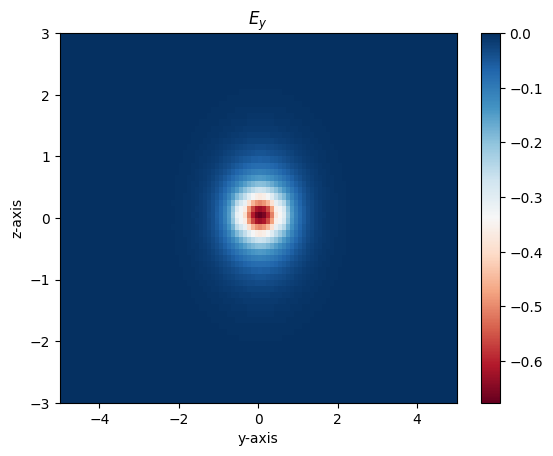

In [30]:
m1.plot_ey()

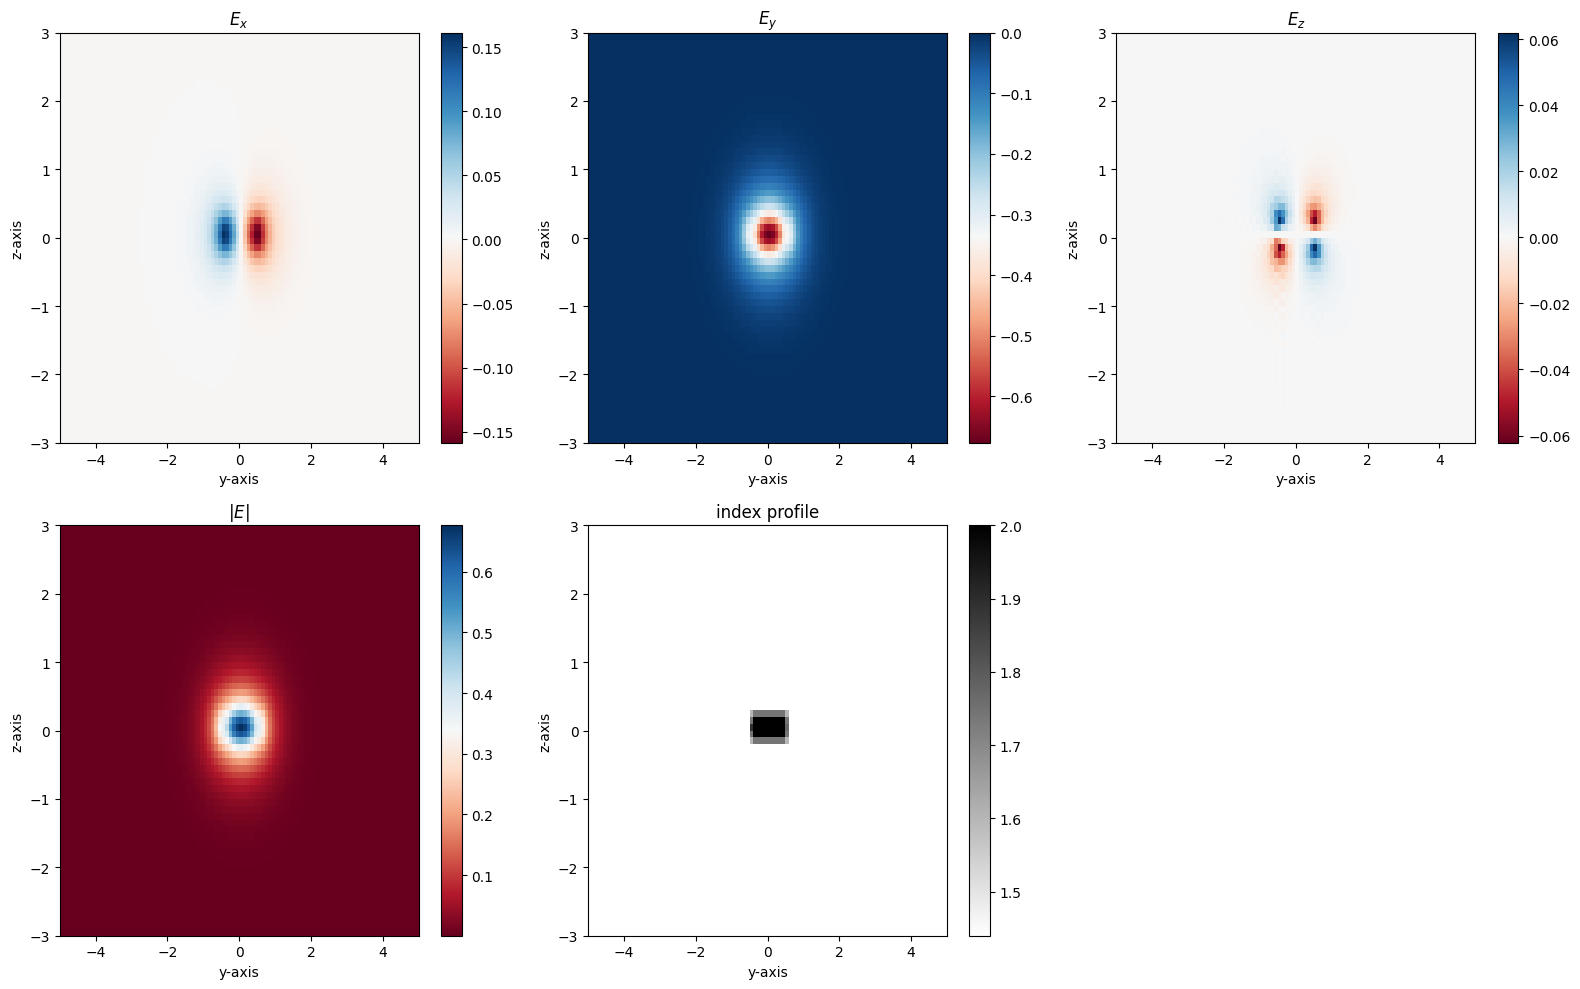

In [31]:
m1.plot_e_all()

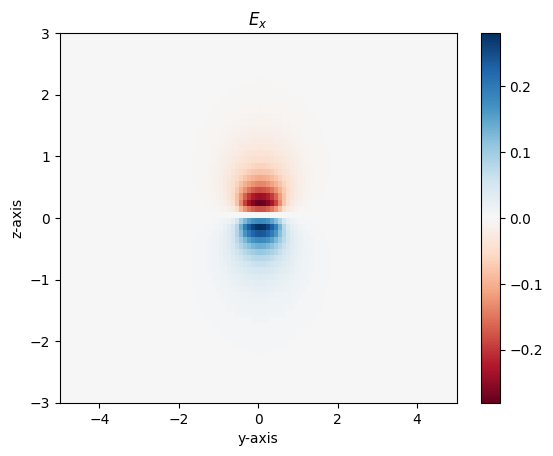

In [32]:
m2.plot_ex()

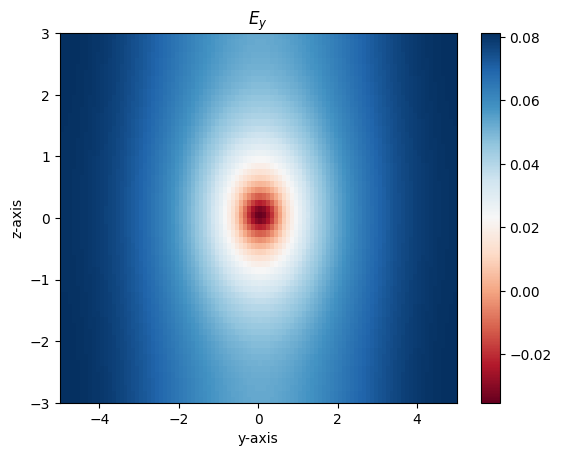

In [33]:
m3.plot_ey()

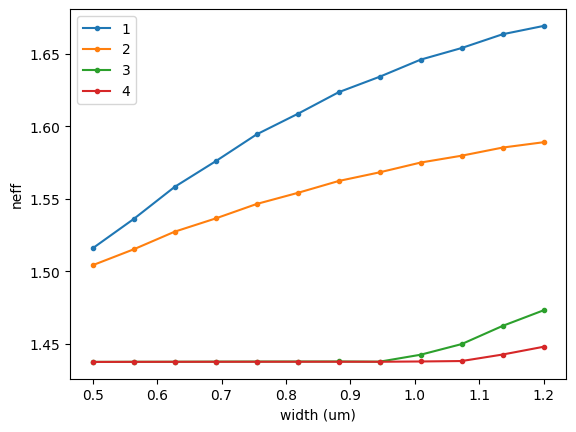

In [34]:
df = gm.find_neff_vs_width(
    width1=0.5,
    width2=1.2,
    wg_thickness=0.4,
    ncore=2.0,
    sy=10.0,
    resolution=15,
    filepath="neff_vs_width_nitride.csv",
)
gm.plot_neff_vs_width(df)

## Dispersion

To get the effective index we only need to compute the mode propagation constant at a single frequency.

However, to compute the dispersion (group delay) we need to compute the effective index for at least 3 wavelengths.

The effective index `neff` relates to the speed of the phase evolution of the light, while the group index `ng` relates to the group velocity of the light.

To compute the resonances in MZI interferometers or ring resonators you need to use `ng`

In [35]:
gm.find_mode_dispersion?

In [36]:
m = gm.find_mode_dispersion()

INFO:rich:Using client version: 1.7.1


2022-11-07 00:11:59.206 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.7.1' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


/home/runner/work/gdsfactory/gdsfactory/gdsfactory/types.py:209: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(val, dtype=cls.inner_type)


In [37]:
m.ng

4.27036551816398

## Convergence tests

Before launching a set of simulations you need to make sure you have the correct simulation settings:

- resolution: resolution
- sx: Size of the simulation region in the x-direction (default=4.0)
- sy: Size of the simulation region in the y-direction (default=4.0)


In [38]:
import gdsfactory.simulation.modes as gm
import numpy as np
import matplotlib.pyplot as plt

resolutions = np.linspace(10, 50, 5)
neffs = []

for resolution in resolutions:
    modes = gm.find_modes_waveguide(
        wg_width=0.5, ncore=3.5, nclad=1.44, wg_thickness=0.22, resolution=resolution
    )
    mode = modes[1]
    neffs.append(mode.neff)

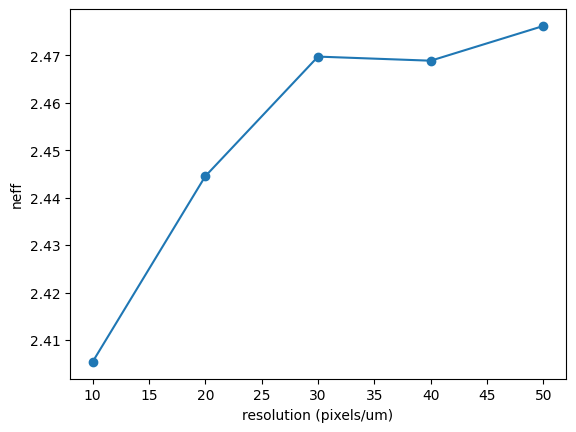

In [39]:
plt.plot(resolutions, neffs, "o-")
plt.ylabel("neff")
plt.xlabel("resolution (pixels/um)")

In [40]:
szs = np.linspace(4, 6, 6)
neffs = []

for sz in szs:
    modes = gm.find_modes_waveguide(
        wg_width=0.5, ncore=3.5, nclad=1.44, wg_thickness=0.22, resolution=20, sz=sz
    )
    mode = modes[1]
    neffs.append(mode.neff)

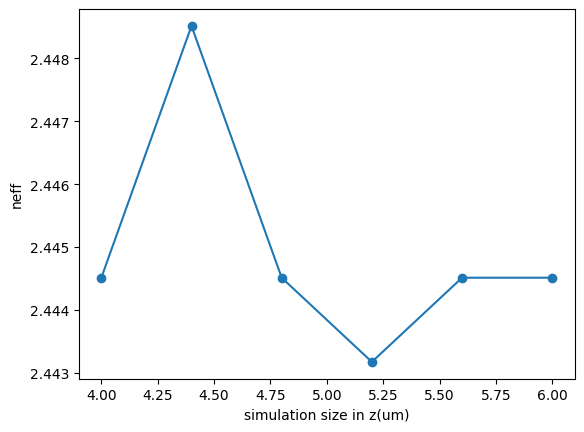

In [41]:
plt.plot(szs, neffs, "o-")
plt.ylabel("neff")
plt.xlabel("simulation size in z(um)")

In [42]:
sys = np.linspace(2, 6, 6)
neffs = []

for sy in sys:
    modes = gm.find_modes_waveguide(
        wg_width=0.5, ncore=3.5, nclad=1.44, wg_thickness=0.22, resolution=20, sy=sy
    )
    mode = modes[1]
    neffs.append(mode.neff)

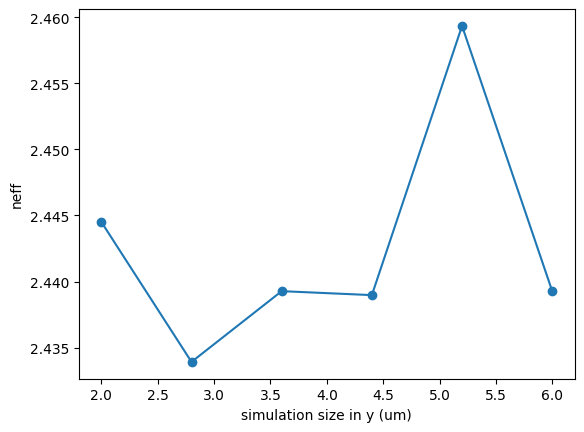

In [43]:
plt.plot(sys, neffs, "o-")
plt.ylabel("neff")
plt.xlabel("simulation size in y (um)")

## Find modes coupler

When two waveguides are close to each other, they support modes that travel with different index (speed). One of the modes is an even mode, while the other one is an odd mode.

Light will couple from one waveguide to another because the even and odd modes travel at different speeds and they interfere with each other. Creating a periodically back and forth coupling between both waveguides.

Depending on the length of the coupling region and the gap there will be a different percentage of the light coupled from one to another


```bash

          _____________________________________________________
          |
          |
          |         widths[0]                 widths[1]
          |     <---------->     gaps[0]    <---------->
          |      ___________ <-------------> ___________      _
          |     |           |               |           |     |
        sz|_____|  ncore    |_______________|           |_____|
          |                                                   | wg_thickness
          |slab_thickness        nslab                        |
          |___________________________________________________|
          |
          |<--->                                         <--->
          |ymargin               nclad                   ymargin
          |____________________________________________________
          <--------------------------------------------------->
                                   sy


```

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory.simulation.modes as gm

In [45]:
modes = gm.find_modes_coupler(
    wg_widths=(0.5, 0.5),
    gaps=(0.2,),
    ncore=3.47,
    nclad=1.44,
    wg_thickness=0.22,
    resolution=20,
    sz=6,
    nmodes=4,
)
m1 = modes[1]
m2 = modes[2]
m3 = modes[3]

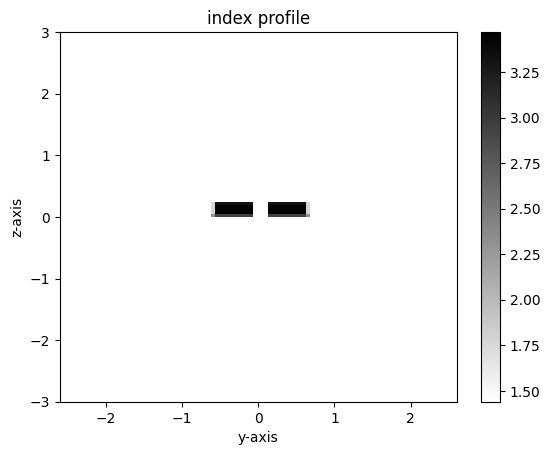

In [46]:
m1.plot_eps()

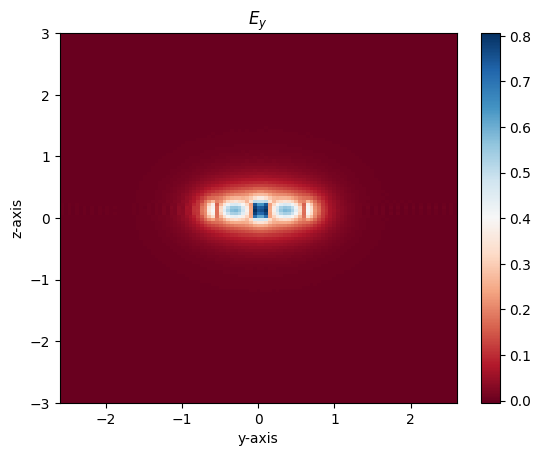

In [47]:
m1.plot_ey()  # even mode

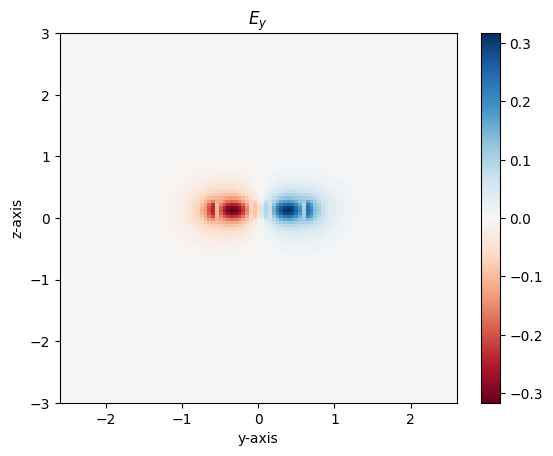

In [48]:
m2.plot_ey()  # odd mode

### Find coupling vs gap

In [49]:
gm.find_coupling_vs_gap?

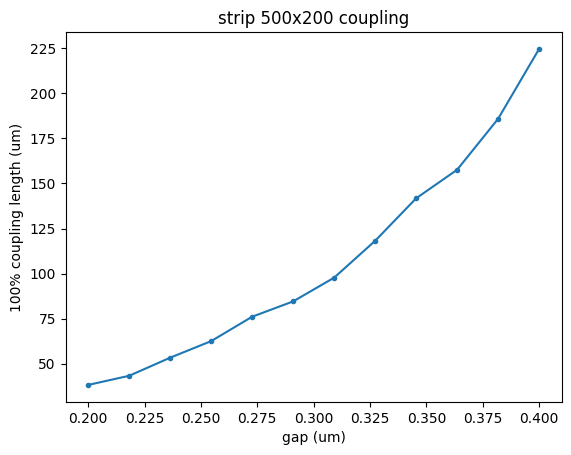

In [50]:
df = gm.coupler.find_coupling_vs_gap(
    gap1=0.2,
    gap2=0.4,
    steps=12,
    nmodes=4,
    wavelength=1.55,
    filepath="find_coupling_vs_gap_strip.csv",
)

plt.title("strip 500x200 coupling")
gm.plot_coupling_vs_gap(df)

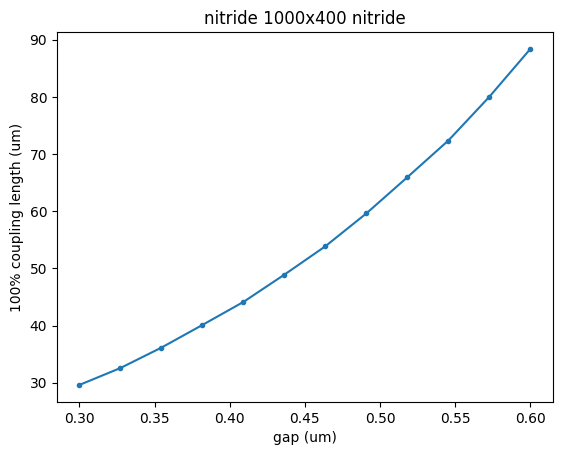

In [51]:
df = gm.coupler.find_coupling_vs_gap_nitride(
    filepath="find_coupling_vs_gap_nitride.csv"
)

plt.title("nitride 1000x400 nitride")
gm.plot_coupling_vs_gap(df)

In [52]:
ne = []
no = []
gaps = [0.2, 0.25, 0.3]

for gap in gaps:
    modes = gm.find_modes_coupler(
        wg_widths=(0.5, 0.5),
        gaps=(gap,),
        ncore=3.47,
        nclad=1.44,
        wg_thickness=0.22,
        resolution=20,
        sz=6,
        nmodes=4,
    )
    ne.append(modes[1].neff)
    no.append(modes[2].neff)

In [53]:
import numpy as np


def coupling_length(
    neff1: float,
    neff2: float,
    power_ratio: float = 1.0,
    wavelength: float = 1.55,
) -> float:
    """
    Returns the coupling length (um) of the directional coupler
    to achieve power_ratio

    Args:
        neff1: even supermode of the directional coupler.
        neff2: odd supermode of the directional coupler.
        power_ratio: p2/p1, where 1 means 100% power transfer
        wavelength: in um

    """
    dneff = (neff1 - neff2).real
    return wavelength / (np.pi * dneff) * np.arcsin(np.sqrt(power_ratio))

In [54]:
lc = [
    coupling_length(neff1=neff1, neff2=neff2) for gap, neff1, neff2 in zip(gaps, ne, no)
]

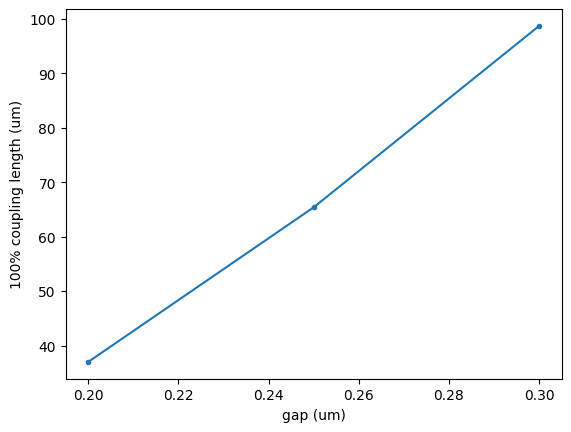

In [55]:
plt.plot(gaps, lc, ".-")
plt.ylabel("100% coupling length (um)")
plt.xlabel("gap (um)")

## Heater efficiency

You can simulate the index change effect from a heater in MPB

Lets assume the temperature increases by 10C (the actual increase does not matter)

**Question**

What is the optimal waveguide width for maximum index change?

In [56]:
from tqdm.auto import tqdm
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gdsfactory.simulation.modes as gm

In [57]:
dn_dt_si = 1.87e-4
dn_dt_sio2 = 8.5e-6

In [58]:
wg_widths = np.arange(0.4, 1.3, 0.2)
wg_widths

array([0.4, 0.6, 0.8, 1. , 1.2])

In [59]:
filepath = pathlib.Path("neff_vs_temperature.csv")

In [60]:
if filepath.exists:
    df = pd.read_csv(filepath)
    dt = 10

else:
    dneffs = []
    for wg_width in tqdm(wg_widths):
        dt = 0
        modes_t0 = gm.find_modes_waveguide(
            wg_width=wg_width,
            ncore=3.47 + dn_dt_si * dt,
            nclad=1.44 + dn_dt_sio2 * dt,
            wg_thickness=0.22,
            resolution=20,
            sy=6,
            sz=6,
            nmodes=4,
        )
        m1 = modes_t0[1]
        neff_t0 = m1.neff

        dt = 10
        modes_t1 = gm.find_modes_waveguide(
            wg_width=wg_width,
            ncore=3.47 + dn_dt_si * dt,
            nclad=1.44 + dn_dt_sio2 * dt,
            wg_thickness=0.22,
            resolution=20,
            sy=6,
            sz=6,
            nmodes=4,
        )
        m1 = modes_t1[1]
        neff_t1 = m1.neff

        dneff = neff_t1 - neff_t0
        dneffs.append(dneff)

    df = pd.DataFrame(dict(wg_width=wg_widths, dneff=dneffs))
    df.to_csv(filepath)

In [61]:
wg_widths = df.wg_width
dneffs = df.dneff

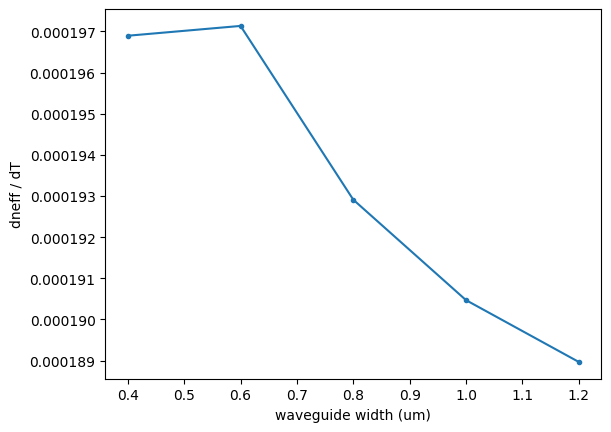

In [62]:
plt.plot(wg_widths, np.array(dneffs) / dt, ".-")
plt.xlabel("waveguide width (um)")
plt.ylabel("dneff / dT")

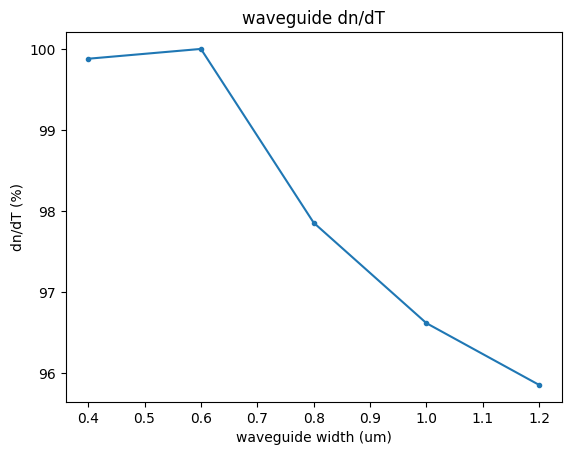

In [63]:
dndt = np.array(dneffs) / dt
plt.plot(wg_widths, dndt / max(dndt) * 100, ".-")
plt.title("waveguide dn/dT")
plt.xlabel("waveguide width (um)")
plt.ylabel("dn/dT (%)")